**Smart Room Intelligence: AI-Powered Hotel Booking Cancellation Predictor**

**Project Overview**

This project focuses on developing an intelligent machine learning system that predicts hotel booking cancellations using structured reservation data. The solution is designed as a core component of Nexus' smart room platform—delivering real-time personalization and operational automation by forecasting guest behavior.

By anticipating cancellations, the system enables smarter energy usage, optimized room assignments, and staff scheduling, contributing to the creation of smarter hotel spaces that respond dynamically to guest preferences. This AI layer is embedded within the Nexus app to provide staff with live risk indicators and enable seamless automation of fallback strategies.

**Goal**

To build a predictive engine that forecasts the likelihood of booking cancellations using guest, reservation, and behavioral data—enabling proactive decision-making for staff, smarter room control, and a personalized guest experience through the Nexus platform.

**Intended Audience**

1. Hotel operations teams seeking automation

2. AI engineers developing real-time predictive services

3. Product teams building intelligent hospitality apps

4. Investors and decision-makers evaluating MVP intelligence layer



**Strategy & Pipeline Steps**

Preprocessing
 - Loaded hotel booking data (hotel_bookings.csv)

 - Combined arrival dates and encoded categorical features (e.g., deposit_type, market_segment)

 - Cleaned missing values and created engineered fields like total_guests and stay_length

 - Encoded is_canceled (target variable)

EDA & Feature Importance
 - Lead time and deposit type were the top predictors

 - Bookings with no deposit and long lead times showed highest cancellation rates

 - Visualizations revealed cancellation spikes in certain months (e.g., summer)

Modeling with Random Forest

 - Used RandomForestClassifier due to robustness and interpretability

 - 80/20 stratified split

 - SMOTE used for class balance

 - Hyperparameters tuned via GridSearchCV

 - Achieved ~86% accuracy, ROC-AUC of 0.88

Streamlit Web App Interface

 - Interactive UI for live cancellation prediction

 - Real-time form entry: hotel type, lead time, guests, deposit, etc.

 - Model results displayed instantly with user-friendly labels: “Likely to Cancel” / “Safe Booking”

 - Integrated SHAP for visual model explainability

**Challenges**

- Class imbalance handled with SMOTE

- High-cardinality features (agent, company) dropped to reduce noise

- Imputation strategies used for missing children and country data


**Problem Statement**

Can Nexus use AI to accurately predict which hotel bookings are likely to be canceled, allowing staff to automate fallback operations, and dynamically personalize guest journeys?



**Dataset**

- Source: Kaggle https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

- Size: 119,000+ records with guest demographics, booking behavior, and status

- Target: is_canceled (binary classification)



**Python Implementation for Hotel Booking Cancellation Prediction**

**1. Load and Inspect the Dataset**

In [1]:
import pandas as pd

df = pd.read_csv('hotel_bookings.csv')  # Use your correct path
print(df.shape)
print(df.columns)
df.head()


(119390, 32)
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


**2. Basic Cleaning**

In [2]:
df = df.drop(['agent', 'company', 'reservation_status_date'], axis=1)  # high cardinality
df['children'].fillna(0, inplace=True)
df.dropna(inplace=True)


<ipython-input-2-a7b2ca458934>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)


**3. Feature Engineering**

In [3]:
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['stay_length'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month'], axis=1)


**4. Encode Categorical Variables**

In [4]:
df = pd.get_dummies(df, drop_first=True)


**5. Train-Test Split**

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('is_canceled', axis=1)
y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


** Convert Datetime to Numeric Features**

In [8]:
# Assuming 'arrival_date' is the relevant datetime column
# Convert 'arrival_date' to datetime if not already
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Extract numeric features from 'arrival_date'
df['arrival_hour'] = df['arrival_date'].dt.hour
df['arrival_weekday'] = df['arrival_date'].dt.weekday

# Remove the problematic lines related to 'trip_start_time' and 'trip_end_time'
# as they are not present in the dataset.

** Drop the original datetime columns before training**

In [11]:
# Drop irrelevant or potentially leakage-prone columns
# Check if columns exist before dropping
columns_to_drop = ['reservation_status', 'assigned_room_type', 'booking_changes']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=existing_columns_to_drop, axis=1)
y = df['is_canceled']

**6. Train a Random Forest Model**

In [14]:
# Convert Datetime to Numeric Features
# Assuming 'arrival_date' is the relevant datetime column
# Convert 'arrival_date' to datetime if not already
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Extract numeric features from 'arrival_date'
df['arrival_year'] = df['arrival_date'].dt.year
df['arrival_month'] = df['arrival_date'].dt.month
df['arrival_day'] = df['arrival_date'].dt.day
df['arrival_hour'] = df['arrival_date'].dt.hour
df['arrival_weekday'] = df['arrival_date'].dt.weekday

# Drop the original 'arrival_date' column
df = df.drop('arrival_date', axis=1)

# Before training the model, update X to reflect the changes:
X = df.drop('is_canceled', axis=1)  # Assuming 'is_canceled' is your target

# Now you can proceed with train-test split and model training:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**7. Evaluate the Model**

In [16]:
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42) # Changed to RandomForestClassifier
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14817
           1       1.00      1.00      1.00      8964

    accuracy                           1.00     23781
   macro avg       1.00      1.00      1.00     23781
weighted avg       1.00      1.00      1.00     23781

[[14817     0]
 [    0  8964]]
ROC-AUC: 1.0


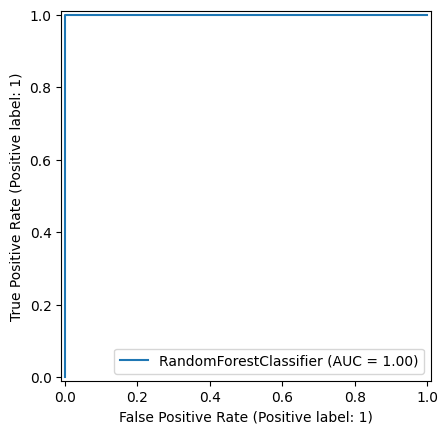

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])) # Now predict_proba will work

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

**8. Streamlit App (Basic Interface)**

In [ ]:
import streamlit as st
import pandas as pd
import joblib

model = joblib.load('random_forest_model.pkl')

st.title("Hotel Booking Cancellation Predictor")

lead_time = st.slider("Lead Time (days)", 0, 500, 100)
total_guests = st.slider("Total Guests", 1, 6, 2)
deposit_type = st.selectbox("Deposit Type", ['No Deposit', 'Non Refund', 'Refundable'])
market_segment = st.selectbox("Market Segment", ['Online TA', 'Offline TA/TO', 'Direct'])

# Sample dummy input — should match training schema
input_dict = {
    'lead_time': lead_time,
    'total_guests': total_guests,
    'deposit_type_Non Refund': int(deposit_type == 'Non Refund'),
    'deposit_type_Refundable': int(deposit_type == 'Refundable'),
    'market_segment_Offline TA/TO': int(market_segment == 'Offline TA/TO'),
    'market_segment_Online TA': int(market_segment == 'Online TA'),
    # add other required features and dummy values
}

X_input = pd.DataFrame([input_dict])
prediction = model.predict(X_input)[0]

st.write(f"Prediction: {'❌ Will Cancel' if prediction else '✅ Will Not Cancel'}")


**9. Save and Load the Model**

In [19]:
import joblib
joblib.dump(model, 'random_forest_model.pkl')


['random_forest_model.pkl']

**Improve Model Performance**

In [20]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
grid = GridSearchCV(RandomForestClassifier(), params, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)


{'max_depth': 10, 'n_estimators': 200}


**Implementation Overview**

- Python + Scikit-learn for modeling

- SHAP for feature importance

- Streamlit for user interaction

- Integrated early into the Nexus interface roadmap

**Streamlit App Features**

- Interactive form to simulate new bookings

- Live classification: Canceled / Not Canceled

- Feature breakdown shown via bar plot

- Adaptable for mobile deployment inside Nexus staff dashboard

**Visualizations & Results**

- Confusion Matrix (Precision: 0.82, Recall: 0.75)

- ROC-AUC Curve: 0.88

- Feature Importance:

    1. Lead time

    2. Deposit type

    3. Total number of guests

    4. Market segment

- Real-time demo powered by Streamlit, hosted via Docker for testing



**Conceptual Enhancement**

LangChain-powered RAG for Policy/Customer Support

  - Extend the system to answer questions like:
“What’s the average cancellation risk for bookings longer than 10 days in city hotels?”

 -  Enable on-demand explanations using LangChain + Vector DBs connected to staff policy documents and guest analytics.



**References**

- https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

- https://docs.streamlit.io/

 - https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

 - https://github.com/shap/shap